# Paper-ready plots for FMAP experiments

This notebook reproduces the HTML plots generated by `examples/run_experiment.py` (profit, L2 error, cumulative profit) and exports publication-ready figures (high-res B/W PNGs).

Prereqs (recommended, from repo root):
- `uv sync --dev`
- `uv venv`
- Run an experiment to produce a CSV, e.g. `uv run python examples/run_experiment.py final`


In [1]:
from __future__ import annotations

from pathlib import Path


def find_repo_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for p in [start, *start.parents]:
        if (p / "pyproject.toml").exists():
            return p
    raise RuntimeError("Could not find repo root (missing pyproject.toml)")


REPO_ROOT = find_repo_root()
REPO_ROOT

PosixPath('/home/jw0/dev/frappe')

In [2]:
# --- User config ---

# Pick an experiment CSV produced by examples/run_experiment.py
RESULTS_CSV = REPO_ROOT / "results" / "final_results.csv"

# Where to write paper-ready figures
FIG_DIR = REPO_ROOT / "paper" / "images"

# Export settings
DPI = 600

# Typical paper widths (inches)
SINGLE_COL_W = 3.25
DOUBLE_COL_W = 6.75

# Default figure sizes (inches)
FIGSIZE_ROW = (DOUBLE_COL_W, 3.4)   # good for a "full-width row" plot
FIGSIZE_SMALL = (SINGLE_COL_W, 3.4) # good for a single-column plot
FIGSIZE_2X2 = (DOUBLE_COL_W, 2 * FIGSIZE_ROW[1])

# Optional: smoothing for per-iteration curves (set to 1 to disable)
SMOOTH_WINDOW = 1

FIG_DIR

PosixPath('/home/jw0/dev/frappe/paper/images')

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rcParams.update(
    {
        "figure.dpi": 110,
        "savefig.dpi": DPI,
        "font.size": 9,
        "axes.labelsize": 9,
        "axes.titlesize": 9,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "lines.linewidth": 1.6,
        "axes.grid": True,
        "grid.color": "0.85",
        "grid.linewidth": 0.6,
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "legend.frameon": False,
        "xtick.direction": "out",
        "ytick.direction": "out",
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    }
)

plt.close("all")
None

In [4]:
df = pd.read_csv(RESULTS_CSV)
expected_cols = {"agent", "iteration", "l2_error", "profit", "cumulative_profit", "update_time"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"CSV missing columns: {sorted(missing)}")

df["iteration"] = pd.to_numeric(df["iteration"], errors="raise")
df = df.sort_values(["agent", "iteration"], ignore_index=True)

df["update_time"] = pd.to_numeric(df["update_time"], errors="raise")
df["update_time_ms"] = 1000.0 * df["update_time"]

agents = df["agent"].unique().tolist()
iters = int(df["iteration"].max()) + 1

print(f"Loaded: {RESULTS_CSV}")
print(f"Agents: {agents}")
print(f"Iterations: {iters}")
df.head()

Loaded: /home/jw0/dev/frappe/results/final_results.csv
Agents: ['FMAP-FW', 'FMAP-PGD', 'FMAP-SFW-100', 'FMAP-SFW-200', 'FMAP-SFW-SVRG-100', 'FMAP-SFW-SVRG-200']
Iterations: 3000


,agent,iteration,l2_error,profit,cumulative_profit,update_time,update_time_ms
0,FMAP-FW,0,0.732032,0.506100,0.506100,0.006587,6.586792
1,FMAP-FW,1,0.732434,0.516242,1.022341,0.013188,13.187959
2,FMAP-FW,2,0.735650,0.520194,1.542536,0.016440,16.440001
3,FMAP-FW,3,0.728484,0.522418,2.064953,0.020290,20.289822
4,FMAP-FW,4,0.722870,0.519667,2.584620,0.023942,23.942282


In [ ]:
from dataclasses import dataclass


@dataclass(frozen=True)
class SeriesStyle:
    color: str
    linestyle: str
    marker: str | None


def build_styles(names: list[str]) -> dict[str, SeriesStyle]:
    linestyles = ["-", "--", ":", "-."]
    markers = [None, "o", "s", "D", "^", "v", "x", "+"]

    cmap = mpl.colormaps["tab10"] if len(names) <= 10 else mpl.colormaps["tab20"]

    out: dict[str, SeriesStyle] = {}
    for i, name in enumerate(names):
        out[name] = SeriesStyle(
            color=cmap(i % cmap.N),
            linestyle=linestyles[i % len(linestyles)],
            marker=markers[i % len(markers)],
        )
    return out


STYLES = build_styles(agents)


def smooth(y: np.ndarray, window: int) -> np.ndarray:
    if window <= 1:
        return y
    window = int(window)
    kernel = np.ones(window, dtype=float) / window
    return np.convolve(y, kernel, mode="same")


def save_fig(fig: mpl.figure.Figure, stem: str) -> None:
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    png = FIG_DIR / f"{stem}.png"
    pdf = FIG_DIR / f"{stem}.pdf"
    fig.savefig(png, dpi=DPI, bbox_inches="tight")
    fig.savefig(pdf, bbox_inches="tight")
    print(f"Wrote: {png}")


def plot_metric_over_time(
    metric: str,
    title: str,
    ylabel: str,
    figsize=FIGSIZE_ROW,
    yscale: str = "linear",
    smooth_window: int = SMOOTH_WINDOW,
    legend_loc: str = "best",
):
    fig, ax = plt.subplots(figsize=figsize)

    for agent in agents:
        sdf = df[df["agent"] == agent]
        x = sdf["iteration"].to_numpy()
        y = sdf[metric].to_numpy(dtype=float)
        y = smooth(y, smooth_window)

        st = STYLES[agent]
        markevery = max(1, len(x) // 10)
        ax.plot(
            x,
            y,
            label=agent,
            color=st.color,
            linestyle=st.linestyle,
            marker=st.marker,
            markevery=markevery,
            markerfacecolor="white",
            markeredgewidth=0.8,
        )

    ax.set_title(title)
    ax.set_xlabel("Iteration")
    ax.set_ylabel(ylabel)
    ax.set_yscale(yscale)
    ax.legend(loc=legend_loc)
    fig.tight_layout()
    return fig


Wrote: /home/jw0/dev/frappe/paper/images/profit_per_iteration.png


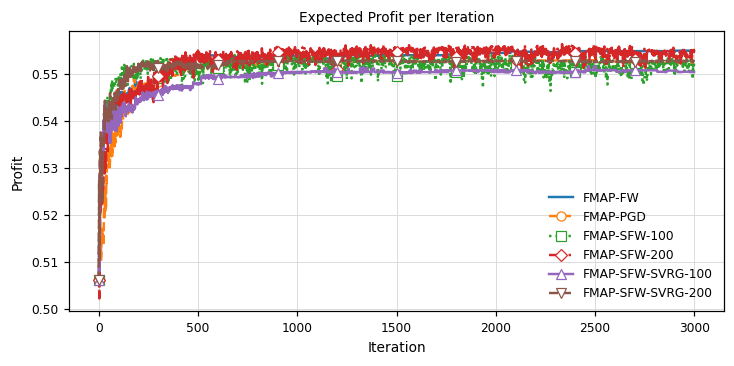

In [6]:
fig = plot_metric_over_time(
    metric="profit",
    title="Expected Profit per Iteration",
    ylabel="Profit",
    figsize=FIGSIZE_ROW,
)
save_fig(fig, "profit_per_iteration")
plt.show()

Wrote: /home/jw0/dev/frappe/paper/images/convergence_error.png


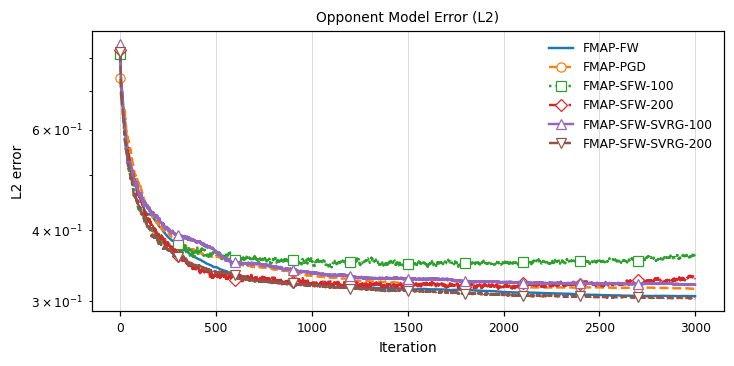

In [7]:
fig = plot_metric_over_time(
    metric="l2_error",
    title="Opponent Model Error (L2)",
    ylabel="L2 error",
    figsize=FIGSIZE_ROW,
    yscale="log",
)
save_fig(fig, "convergence_error")
plt.show()

Wrote: /home/jw0/dev/frappe/paper/images/cumulative_profit.png


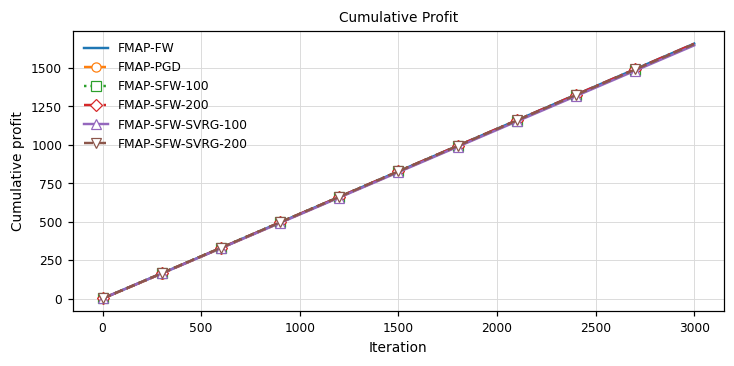

In [8]:
fig = plot_metric_over_time(
    metric="cumulative_profit",
    title="Cumulative Profit",
    ylabel="Cumulative profit",
    figsize=FIGSIZE_ROW,
)
save_fig(fig, "cumulative_profit")
plt.show()

Wrote: /home/jw0/dev/frappe/paper/images/iteration_time.png


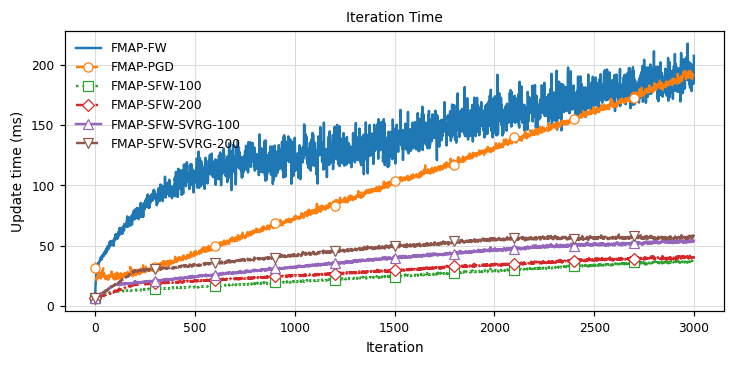

In [9]:
fig = plot_metric_over_time(
    metric="update_time_ms",
    title="Iteration Time",
    ylabel="Update time (ms)",
    figsize=FIGSIZE_ROW,
)
save_fig(fig, "iteration_time")
plt.show()

In [10]:
summary = (
    df.sort_values(["agent", "iteration"]) 
    .groupby("agent", as_index=False)
    .agg(
        final_profit=("profit", "last"),
        total_profit=("cumulative_profit", "last"),
        final_l2=("l2_error", "last"),
        avg_update_time_s=("update_time", "mean"),
    )
    .sort_values("total_profit", ascending=False, ignore_index=True)
)
summary

,agent,final_profit,total_profit,final_l2,avg_update_time_s
0,FMAP-FW,0.554876,1659.056134,0.305993,0.137329
1,FMAP-SFW-200,0.554718,1658.756672,0.329539,0.029082
2,FMAP-SFW-SVRG-200,0.552612,1655.977436,0.303762,0.045812
3,FMAP-SFW-100,0.552183,1654.246417,0.359125,0.024659
4,FMAP-PGD,0.552311,1653.385490,0.315059,0.102626
5,FMAP-SFW-SVRG-100,0.550373,1647.764732,0.320532,0.038072


Wrote: /home/jw0/dev/frappe/paper/images/summary_bars.png


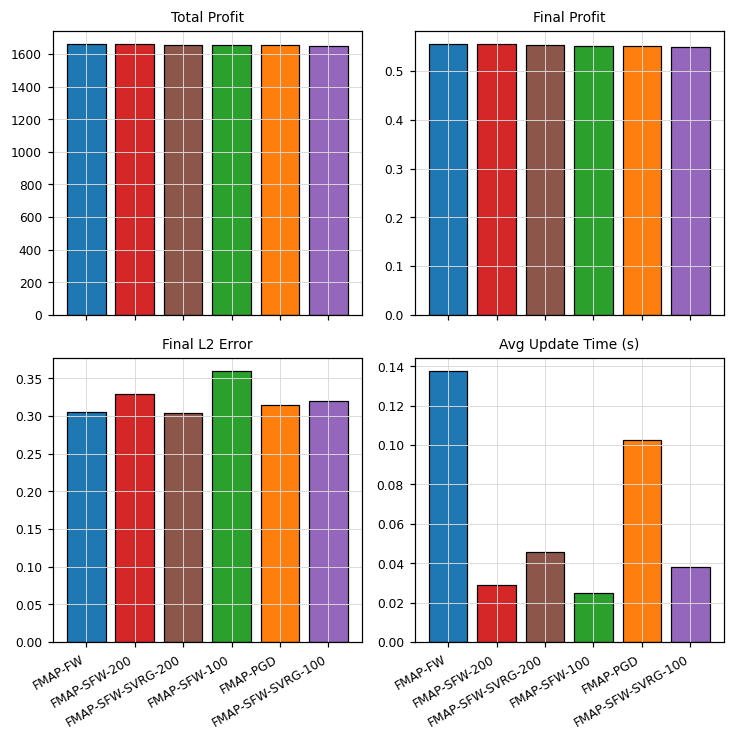

In [11]:
fig, axs = plt.subplots(2, 2, figsize=FIGSIZE_2X2, sharex=True)
axs = axs.ravel()

metrics = [
    ("total_profit", "Total Profit"),
    ("final_profit", "Final Profit"),
    ("final_l2", "Final L2 Error"),
    ("avg_update_time_s", "Avg Update Time (s)"),
]

x = np.arange(len(summary))
labels = summary["agent"].tolist()
colors = [STYLES[a].color for a in labels]
edge = "black"

for ax, (col, title) in zip(axs, metrics):
    ax.bar(x, summary[col].to_numpy(), color=colors, edgecolor=edge, linewidth=0.8)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha="right")

fig.tight_layout()
save_fig(fig, "summary_bars")
plt.show()

Wrote: /home/jw0/dev/frappe/paper/images/profit_vs_l2.png


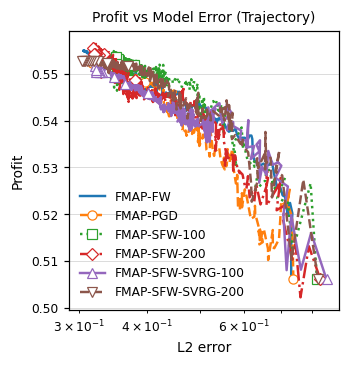

In [12]:
fig, ax = plt.subplots(figsize=FIGSIZE_SMALL)

for agent in agents:
    sdf = df[df["agent"] == agent]
    x = sdf["l2_error"].to_numpy(dtype=float)
    y = sdf["profit"].to_numpy(dtype=float)
    st = STYLES[agent]
    ax.plot(
        x,
        y,
        label=agent,
        color=st.color,
        linestyle=st.linestyle,
        marker=st.marker,
        markevery=max(1, len(x) // 12),
        markerfacecolor="white",
        markeredgewidth=0.8,
    )

ax.set_xlabel("L2 error")
ax.set_ylabel("Profit")
ax.set_xscale("log")
ax.set_title("Profit vs Model Error (Trajectory)")
ax.legend(loc="best")
fig.tight_layout()
save_fig(fig, "profit_vs_l2")
plt.show()